In [1]:
# Cell 1: Imports
import json
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW
import numpy as np
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score
import re
import string
from tqdm import tqdm
import matplotlib.pyplot as plt

print("All libraries imported successfully!")

All libraries imported successfully!


In [2]:
def load_tamil_data(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

In [3]:
class TamilQADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.examples = []
        processed_count = 0
        
        for entry in tqdm(data["data"]):
            for paragraph in entry["paragraphs"]:
                context = paragraph["context"]
                for qa in paragraph["qas"]:
                    if not qa["is_impossible"]:
                        for answer in qa["answers"]:
                            example = self.process_qa_pair(
                                qa["question"], 
                                context, 
                                answer, 
                                tokenizer, 
                                max_length
                            )
                            if example:
                                self.examples.append(example)
                                processed_count += 1
        
        print(f"Successfully processed {processed_count} QA pairs")

    def process_qa_pair(self, question, context, answer, tokenizer, max_length):
        tokenized = tokenizer(
            question,
            context,
            truncation=True,
            max_length=max_length,
            padding="max_length",
            return_offsets_mapping=True,
            return_tensors="pt"
        )
        
        offset_mapping = tokenized["offset_mapping"].squeeze(0)
        answer_start = answer["answer_start"]
        answer_text = answer["text"]
        
        start_pos = end_pos = None
        for idx, (start, end) in enumerate(offset_mapping):
            if start <= answer_start < end:
                start_pos = idx
            if start < answer_start + len(answer_text) <= end:
                end_pos = idx
                break
                
        if start_pos is None or end_pos is None:
            return None
            
        return {
            "input_ids": tokenized["input_ids"].squeeze(0),
            "attention_mask": tokenized["attention_mask"].squeeze(0),
            "start_positions": torch.tensor(start_pos, dtype=torch.long),
            "end_positions": torch.tensor(end_pos, dtype=torch.long)
        }

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        return self.examples[idx]


In [4]:
# Execute data loading and preprocessing
print("Starting data preprocessing...")
tokenizer = AutoTokenizer.from_pretrained("google/muril-base-cased")
data = load_tamil_data("answers (1).json")
dataset = TamilQADataset(data, tokenizer)

Starting data preprocessing...


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 34.25it/s]

Successfully processed 499 QA pairs


In [5]:
# Create train/val split
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [6]:
# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4)

In [7]:
print("Data preprocessing completed!")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Data preprocessing completed!
Training samples: 399
Validation samples: 100


In [8]:
# Cell 3: Model Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [9]:
# Initialize model
model = AutoModelForQuestionAnswering.from_pretrained("google/muril-base-cased")
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)

C:\Users\jathusharini\anaconda3\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\jathusharini\anaconda3\lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  

In [10]:
# Training loop
epochs = 20
training_losses = []
validation_losses = []

In [11]:
print("Starting training...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    # Training phase
    model.train()
    total_loss = 0
    train_progress = tqdm(train_dataloader, desc="Training")
    
    for batch in train_progress:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        train_progress.set_postfix({'loss': f"{loss.item():.4f}"})
    
    avg_train_loss = total_loss / len(train_dataloader)
    training_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0
    val_progress = tqdm(val_dataloader, desc="Validation")
    
    with torch.no_grad():
        for batch in val_progress:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()
            val_progress.set_postfix({'loss': f"{outputs.loss.item():.4f}"})
    
    avg_val_loss = val_loss / len(val_dataloader)
    validation_losses.append(avg_val_loss)
    
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}")

print("Training completed!")

Starting training...

Epoch 1/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:16<00:00,  5.44s/it, loss=5.8924]


Training Loss: 6.0950
Validation Loss: 5.9109

Epoch 2/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:26<00:00,  5.88s/it, loss=5.7224]


Training Loss: 5.8566
Validation Loss: 5.7623

Epoch 3/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:43<00:00,  6.52s/it, loss=5.5572]


Training Loss: 5.7183
Validation Loss: 5.6509

Epoch 4/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:28<00:00,  5.95s/it, loss=5.4238]


Training Loss: 5.5874
Validation Loss: 5.5256

Epoch 5/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:30<00:00,  6.04s/it, loss=5.3584]


Training Loss: 5.4279
Validation Loss: 5.4122

Epoch 6/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:29<00:00,  5.97s/it, loss=5.2208]


Training Loss: 5.2474
Validation Loss: 5.2441

Epoch 7/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:12<00:00,  5.30s/it, loss=4.8266]


Training Loss: 5.0564
Validation Loss: 5.0975

Epoch 8/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:11<00:00,  5.24s/it, loss=4.7671]


Training Loss: 4.8317
Validation Loss: 4.9620

Epoch 9/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:18<00:00,  5.54s/it, loss=4.5263]


Training Loss: 4.5697
Validation Loss: 4.7024

Epoch 10/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:32<00:00,  6.11s/it, loss=4.2855]


Training Loss: 4.2660
Validation Loss: 4.4329

Epoch 11/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:29<00:00,  5.97s/it, loss=4.2693]


Training Loss: 3.9781
Validation Loss: 4.2411

Epoch 12/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [05:30<00:00, 13.22s/it, loss=4.0793]


Training Loss: 3.6597
Validation Loss: 4.1188

Epoch 13/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:13<00:00,  5.36s/it, loss=3.8282]


Training Loss: 3.3437
Validation Loss: 3.9404

Epoch 14/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:15<00:00,  5.44s/it, loss=3.9553]


Training Loss: 3.0772
Validation Loss: 3.7604

Epoch 15/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:15<00:00,  5.40s/it, loss=3.1213]


Training Loss: 2.7116
Validation Loss: 3.4746

Epoch 16/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:12<00:00,  5.30s/it, loss=3.8972]


Training Loss: 2.3330
Validation Loss: 3.6601

Epoch 17/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [02:25<00:00,  5.83s/it, loss=3.8736]


Training Loss: 1.9728
Validation Loss: 3.5192

Epoch 18/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [05:33<00:00, 13.35s/it, loss=3.2498]


Training Loss: 1.6804
Validation Loss: 3.4059

Epoch 19/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [04:32<00:00, 10.92s/it, loss=2.7950]


Training Loss: 1.3907
Validation Loss: 3.2801

Epoch 20/20


Validation: 100%|█████████████████████████████████████████████████████████| 25/25 [04:56<00:00, 11.86s/it, loss=2.5035]

Training Loss: 1.1011
Validation Loss: 3.5127
Training completed!


In [12]:
# Cell 4: Save Model
print("Saving model...")
model.save_pretrained("./latest_muril_model-test-01")
tokenizer.save_pretrained("./latest_muril_model-01")
print("Model saved successfully!")

Saving model...
Model saved successfully!


In [13]:
# Cell 5: Evaluation
def normalize_answer(s):
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punctuation(text):
        return text.translate(str.maketrans('', '', string.punctuation))
    def lower(text):
        return text.lower()
    return white_space_fix(remove_articles(remove_punctuation(lower(s))))

In [14]:
def compute_f1(pred_text, true_text):
    pred_tokens = normalize_answer(pred_text).split()
    true_tokens = normalize_answer(true_text).split()
    
    if len(pred_tokens) == 0 or len(true_tokens) == 0:
        return int(pred_tokens == true_tokens)
    
    common_tokens = set(pred_tokens) & set(true_tokens)
    if not common_tokens:
        return 0
    
    precision = len(common_tokens) / len(pred_tokens)
    recall = len(common_tokens) / len(true_tokens)
    f1 = 2 * precision * recall / (precision + recall)
    return f1

print("Starting evaluation...")
model.eval()
results = {
    'exact_match': [],
    'f1': [],
    'bleu': []
}

Starting evaluation...


In [15]:
with torch.no_grad():
    for batch in tqdm(val_dataloader, desc="Evaluating"):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        
        # Get predictions
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits
        
        for i in range(len(batch['input_ids'])):
            pred_start = torch.argmax(start_logits[i]).item()
            pred_end = torch.argmax(end_logits[i]).item()
            
            pred_tokens = tokenizer.decode(batch['input_ids'][i][pred_start:pred_end + 1])
            true_tokens = tokenizer.decode(
                batch['input_ids'][i][
                    batch['start_positions'][i]:batch['end_positions'][i] + 1
                ]
            )
            
            results['exact_match'].append(
                int(normalize_answer(pred_tokens) == normalize_answer(true_tokens))
            )
            results['f1'].append(compute_f1(pred_tokens, true_tokens))
            results['bleu'].append(
                sentence_bleu([true_tokens.split()], pred_tokens.split())
            )

print("\nEvaluation Results:")
for metric, values in results.items():
    print(f"{metric}: {np.mean(values)*100:.2f}%")

Evaluating:   4%|██▊                                                                    | 1/25 [00:51<20:41, 51.72s/it]C:\Users\jathusharini\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\jathusharini\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\jathusharini\anaconda3\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0,


Evaluation Results:
exact_match: 29.00%
f1: 45.85%
bleu: 20.93%


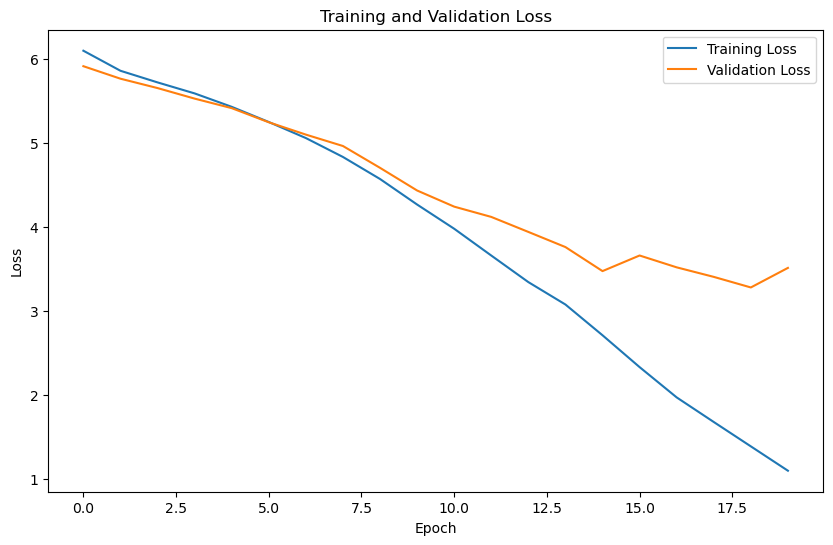

Training history plot saved as 'training_history-test-01.png'


In [16]:
# Cell 6: Plot Training History
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('training_history-test-01.png')
plt.show()
print("Training history plot saved as 'training_history-test-01.png'")